# Connect Three 

The primary description of this coursework is available on the CM20252 Moodle page. This is the Jupyter notebook you must complete and submit to receive marks. This notebook adds additional detail to the coursework specification but does not repeat the information that has already been provided there. 

You must follow all instructions given in this notebook precisely.

Restart the kernel and run all cells before submitting the notebook. This will guarantee that we will be able to run your code for testing. Remember to save your work regularly.

__You will develop players for Connect-Three on a grid that is 5 columns wide and 3 rows high. An example is shown below showing a win for Player Red.__

<img src="images/connect3.png" style="width: 200px;"/>

## Preliminaries

For your reference, below is a visual depiction of the agent-environment interface in reinforcment learning. The interaction of the agent with its environments starts at decision stage $t=0$ with the observation of the current state $s_0$. (Notice that there is no reward at this initial stage.) The agent then chooses an action to execute at decision stage $t=1$. The environment responds by changing its state to $s_1$ and returning the numerical reward signal $r_1$. 

<img src="images/agent-environment.png" style="width: 500px;"/>

<br><br><br>

Below, we provide some code that will be useful for implementing parts of this interface. You are not obligated to use this code; please feel free to develop your own code from scratch. 

### Code details

We provide a `Connect` class that you can use to simulate Connect-Three games. The following cells in this section will walk you through the basic usage of this class by playing a couple of games.

We import the `connect` module and create a Connect-Three environmnet called `env`. The constructor method has one argument called `verbose`. If `verbose=True`, the `Connect` object will regularly print the progress of the game. This is useful for getting to know the provided code, debugging your code, or if you just want to play around. You will want to set `verbose=False` when you run hundreds of episodes to complete the marked exercises.

This `Connect` environment uses the strings `'o'` and `'x'` instead of different disk colors in order to distuingish between the two players.

Before we start a game, we should call the `reset()` method. This method cleans the board and resets other state variables. The `first_player` argument can be specified (`'o'` or `'x'`) to deterministically choose the starting player. It defaults to `"random"`, in which case each player starts the game with probability of $\frac{1}{2}$.

In [162]:
import connect
env = connect.Connect(verbose=True)
env.reset(first_player='o')

Game has been reset.
[[' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ']]


We can interact with the environment using the `act()` method. This method takes an `action` as input and computes the response of the environment. An action is defined as the column index that a disk is dropped into.

In [163]:
env.act(action=2)

[[' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ']
 [' ' ' ' 'o' ' ' ' ']]


The `act()` method inserts a disk into the specified column. 

If we want to change the player on move, we can do so by using the `change_turn()` method. We can check whose turn it is by accessing the `.player_at_turn` attribute.

In [164]:
print("Current player at turn:", env.player_at_turn)
env.change_turn()
print("Current player at turn:", env.player_at_turn)

# Drop another disk into the same centre column.
env.act(action=2)

Current player at turn: o
Current player at turn: x
[[' ' ' ' ' ' ' ' ' ']
 [' ' ' ' 'x' ' ' ' ']
 [' ' ' ' 'o' ' ' ' ']]


Because we set `verbose=True`, the grid is printed each time we call the `act()` method. This grid is stored as a two-dimensional numpy array in the connect class and you can easily access by calling...

In [165]:
current_grid = env.grid
print(current_grid)
# Notice that the grid now appears to be "upside down" because numpy arrays are printed from "top to bottom".

[[' ' ' ' 'o' ' ' ' ']
 [' ' ' ' 'x' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ']]


In [166]:
# Let's make another move.
env.change_turn()
env.act(action=2)

[[' ' ' ' 'o' ' ' ' ']
 [' ' ' ' 'x' ' ' ' ']
 [' ' ' ' 'o' ' ' ' ']]


If we make another move with `act(action=2)`, the environment will throw an error because that column is already filled.

In [167]:
# This cell should throw an error!
env.change_turn()
env.act(action=2)

IndexError: index 3 is out of bounds for axis 0 with size 3

The attribute `.available_actions` contains a numpy array of all not yet filled columns.

In [168]:
print(env.available_actions)
# Column index '2' is missing because this column is already filled

[0 1 3 4]


The `Connect` class contains a method called `was_winning_move()` that checks whether the last move won the game (returns `True`) or not (returns `False`). 

In [169]:
# Obviously the game has not yet been won by any player.
print("Winning move?", env.was_winning_move()) 

# Make some moves
env.act(action=3)
env.change_turn()
env.act(action=1)
env.change_turn()
env.act(action=3)
env.change_turn()
env.act(action=0)

# Check again whether a player has won the game.
print("Winning move?", env.was_winning_move()) 

Winning move? False
[[' ' ' ' 'o' ' ' ' ']
 [' ' ' ' 'x' ' ' ' ']
 [' ' ' ' 'o' 'x' ' ']]
[[' ' ' ' 'o' ' ' ' ']
 [' ' ' ' 'x' ' ' ' ']
 [' ' 'o' 'o' 'x' ' ']]
[[' ' ' ' 'o' ' ' ' ']
 [' ' ' ' 'x' 'x' ' ']
 [' ' 'o' 'o' 'x' ' ']]
[[' ' ' ' 'o' ' ' ' ']
 [' ' ' ' 'x' 'x' ' ']
 ['o' 'o' 'o' 'x' ' ']]
Player ' o ' has won the game!
Winning move? True


Finally, the `Connect` class contains a method called `grid_is_full()` that checks whether the grid still contains empty slots. You can use this method to check whether the game is a draw.

Feel free to modify existing or add new methods to the `Connect` class.

## Part 1: Q-learning

Your opponent is always the first player. Your agent is always the second player.

For your reference, the pseudo-code for Q-learning is reproduced below from the textbook (Reinforcement Learning, Sutton & Barto, 1998, Section 6.5).
<img src="images/q_learning.png" style="width: 600px;"/>

Prepare a **learning curve** following the directions below. We refer to this as Plot 1.

After $n$ steps of interaction with the environment, play $m$ games with the current policy of the agent (without modifying the policy). Think of this as interrupting the agent for a period of time to test how well it has learned so far. Your plot should show the total score obtained in these $m$ games as a function of $n, 2n, 3n, … kn$. The choices of $n$ and $k$ are up to you. They should be reasonable values that demonstrate the efficiency of the learning and how well the agent learns to play the game eventually. Use $m=10$. 

This plot should show the mean performance of $a$ agents, not the performance of a single agent. Because of the stochasticity in the environment, you will obtain two different learning curves from two different agents even though they are using exactly the same algorithm. We suggest setting $a$ to 30 or higher.

Present a single mean learning curve with your choice of parameters $\epsilon$ and $\alpha$. The plot should also show (as a baseline) the mean performance of a random agent that does not learn but chooses actions uniformly randomly from among the legal actions. Label this line “Random Agent”. 

Please include this plot as a static figure in the appropriate cell below. You can look at the source code of this markdown cell to find out how to embed figures using html or you can use drag & drop. If you link to locally stored images, make sure to include those in your submission.

In [170]:
import connect
import numpy as np
import random as r
import matplotlib.pyplot as plt
%matplotlib inline


class RandomAgent:
    
    def __init__(self, env):
        self.env = env
        self.cumulative_reward = 0
    
    def choose_action(self):
        """Chooses action randomly for random agent"""
        actions = self.env.available_actions
        action = r.choice(actions)
        return action

    
class QAgent:
    
    def __init__(self, env, epsilon=0.05, alpha=0.2, gamma=1):
        self.env = env
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        
        # Init Q table
        self.Q = {}
        
        # Default last state action value 
        self.last_state_action = 0.0
        
    def choose_action(self, state):
        """Chooses action based on Q Learning policy, from Q table"""
        state = tuple(state.flatten())
        actions = self.env.available_actions
        if np.random.uniform(0, 1) < self.epsilon:
            action = r.choice(actions)
            return action
        else:
            q_vals = self.get_q_values(state, actions)     
            max_q = max(q_vals)

        if q_vals.count(max_q) > 1:
            indexes = []
            for q in q_vals:
                if q == max_q:
                    indexes.append(q_vals.index(q))
            i = r.choice(indexes)
        else:
            i = q_vals.index(max_q)
        
        self.last_state_action = self.Q[(state, actions[i])]
        return actions[i]
    
    def learn(self, state, state_prime, action, reward):
        """Learning function so Q agent is able to learn"""
        # Flatten states and makes them a tuple.
        state = tuple(state.flatten())
        state_prime = tuple(state_prime.flatten())
        actions = self.env.available_actions
        
        # Gets q values of state prime.
        q_vals_state_prime = self.get_q_values(state_prime, actions)

        # If q values contain <1 max_q's it will choose between them.
        if q_vals_state_prime:
            max_q = max(q_vals_state_prime)
        else:
            max_q = 0.0
            
        # Update q table.
        self.Q[(state, action)] = self.last_state_action + self.alpha * (reward + (self.gamma * max_q) - self.last_state_action)

    def get_q_values(self, state, actions):
        """Gets q values for state and set of actions."""
        q_values = []
        for action in actions:
            q_value = self.get_Q(state, action)
            q_values.append(q_value)
        return q_values
    
    def get_Q(self, s, a):
        """Return q value from q table, given a state and action"""
        if self.Q.get((s, a)) == None:
            self.Q[(s, a)] = 0.0
        return self.Q.get((s, a))

In [171]:
def policy_value(q_table, learn=True, episodes=10):
    """Function performs 10 episodes, and returns current policy value"""
    
    temp_env = connect.Connect(verbose=False)
    r_agent = RandomAgent(temp_env)
    total_reward = []
    
    if learn:
        q_agent = QAgent(temp_env, epsilon=0.0)
        q_agent.Q = q_table
    else: 
        q_agent = QAgent(temp_env, epsilon=1.0)
    
    for episode in range(0, episodes):
        temp_env.reset(first_player='o')
        temp_env.act(r_agent.choose_action())
        
        finished = False
        
        while not finished:
            temp_env.change_turn()
            state = np.copy(temp_env.grid)
            action = q_agent.choose_action(state)
            temp_env.act(action)
            if temp_env.was_winning_move():
                reward = 1
                finished = True
            elif temp_env.grid_is_full():
                reward = 0
                finished = True
            else:
                temp_env.change_turn()
                r_action = r_agent.choose_action()
                temp_env.act(r_action)
                if temp_env.was_winning_move():
                    reward = -1
                    finished = True
                elif temp_env.grid_is_full():
                    reward = 0
                    finished = True
        total_reward.append(reward)
    return sum(total_reward)

In [174]:
def play(env, n, total_steps=90000, learn=True):
    """Main game function, with default 90,000 steps"""
    
    # Inits players.
    r_agent = RandomAgent(env)
    q_agent = QAgent(env)
    
    if not learn:
        q_agent.epsilon = 1.0
    
    # Collects cumulative reward over time.
    cumulative_reward = []
    
    # Initialises games before loop.
    env.reset(first_player='o')
    env.act(r_agent.choose_action())
    
    for step in range(1, total_steps):
        if step % n == 0 or step == 1:  
            temp_q_table = dict(q_agent.Q)
            rewards = policy_value(temp_q_table, learn)
            cumulative_reward.append(rewards)
            env.reset(first_player='o')
            env.act(r_agent.choose_action())

        initial_state = np.copy(env.grid)
        env.change_turn()
        action = q_agent.choose_action(initial_state)
        env.act(action)
        new_state = np.copy(env.grid)
        
        if env.was_winning_move():
            reward = 1
            if learn:
                q_agent.learn(initial_state, new_state, action, reward)
            env.reset(first_player='o')
            env.act(r_agent.choose_action())
        elif env.grid_is_full():
            reward = 0
            if learn:
                q_agent.learn(initial_state, new_state, action, reward)
            env.reset(first_player='o')
            env.act(r_agent.choose_action())
        else:
            env.change_turn()
            r_action = r_agent.choose_action()
            env.act(r_action)
            new_state = np.copy(env.grid)
            if env.was_winning_move():
                reward = -1
                if learn:
                    q_agent.learn(initial_state, new_state, action, reward)
                env.reset(first_player='o')
                env.act(r_agent.choose_action())
            elif env.grid_is_full():
                reward = 0
                if learn:
                    q_agent.learn(initial_state, new_state, action, reward)
                env.reset(first_player='o')
                env.act(r_agent.choose_action())
            else:
                reward = 0
                if learn:
                    q_agent.learn(initial_state, new_state, action, reward)
    return cumulative_reward

In [175]:
# Run cell to output the average rewards of 30 QAgents
lines = []
for i in range(0, 30):
    env = connect.Connect(verbose=False)
    line = play(env, n=1000, total_steps=75000)
    lines.append(line)

q_avg_line = []
for j in range(0, len(line)):
    avg = 0
    for line in lines:
        avg += line[j]
    avg = avg / len(lines)
    q_avg_line.append(avg) 

In [176]:
# Run cell to output the average rewards of 30 RandomAgents
lines = []
for i in range(0, 30):
    env = connect.Connect(verbose=False)
    line = play(env, n=1000, total_steps=75000, learn=False)
    lines.append(line)

r_avg_line = []
for j in range(0, len(line)):
    avg = 0
    for line in lines:
        avg += line[j]
    avg = avg / len(lines)
    r_avg_line.append(avg) 

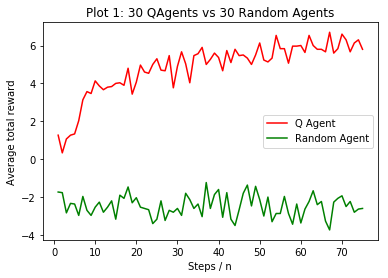

In [178]:
"""Cell is used to plot the graph of 30 Q-Agents and random Agents. 
   Cell must be run after the above 2 cells have also been run """
x = np.arange(1, len(q_avg_line) + 1)
fig, (ax2) = plt.subplots(1,1)
ax2.plot(x, q_avg_line, color="red", label="Q Agent")
ax2.plot(x, r_avg_line, color="green", label="Random Agent")
ax2.set_title("Plot 1: 30 QAgents vs 30 Random Agents")
ax2.set_xlabel('Steps / n')
ax2.set_ylabel('Average total reward' )

plt.legend()
plt.show()

(A) [continued} Insert your static learning curve here (Plot 1).

<img src="images/qvsr.png" style="width: 300px;"/>

(B) In 3 sentences or less, explain your conclusions from the plot above. How close does your (average) agent get to the best possible level of performance? How efficiently does your (average) agent learn? 

My Q agent levels out at an average score of 7, after completing the 90000 steps with the environment. Despite the Q agents ability to learn, it is disadvantages slightly by the fact that the the opposing agent always goes first. This is why the Random agent has an average of -2/-4. 

(C) In five sentences or less, explain the key aspects of your implementation. How many state-action pairs do you represent in your Q-table? Describe and justify your settings of $\alpha$ and $\epsilon$. Are there any things you tried out that are not in your final implementation?

To implement the Q table I used a dictionary, and the keys consisted of a tuple containing the flattened numpy array and the action. Everytime the agent came across a new state it had not seen before, it was saved to the Q table with an initial value of 0. I originally gave alpha a value of 0.1, however changed it to a value of 0.2 as updating the Q value with more information from the environment proved it to learn better. I gave epsilon a value of 0.05 as this meant an exploratoy move was taken on average 1/20 moves, which proved to be a good amount. I was going to implement a decaying epsilon value as the agent learnt more, so it would not be negatively effected by a random move after it had learnt a certain amount. However, I did not implement this because I felt the Agent needed to learn for a longer period of time than the amount given, before it would benefit from not taking exploratory moves.

(D) In the cell below, make it possible for us to produce from scratch a learning curve similar to Plot 1 but for a single agent, for a $k$ value of your own choosing. You do not need to include the baseline for random play.  This code should run in less than 30 seconds (ours runs in 2 seconds). 


Elapsed time:  24.149571000001743


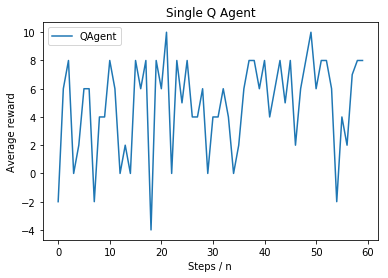

In [196]:
# Run cell to return average rewards of 1 QAgent and the time it takes to compute it. 
import time

t = time.process_time()
env = connect.Connect(verbose=False)
q_line = play(env, n=1000, total_steps=60000)
elapsed_time = time.process_time() - t
print("Elapsed time: ", elapsed_time)

# Plots rewards.
x = np.arange(0, len(q_line))
plt.plot(x, q_line, label="QAgent")
plt.title("Single Q Agent")
plt.xlabel("Steps / n")
plt.ylabel("Average reward")
plt.legend()
plt.show()

## Part 2A
 
Using the minimax policy you computed, answer the following question: The first player (Player 1) drops his/her first disk into column 2 (counting from the left). Consider the resulting state, shown in the following code cell. 

In [ ]:
env = connect.Connect(verbose=False)
env.reset(first_player='o')
env.act(action=1)
print(env.grid[::-1])

What is the Minimax Value of this state for Player 2? That is, assuming an optimal opponent, does the Minimax Policy expect to win the game (value = 1), lose the game (value = –1), or end the game in a draw (value = 0)? Please state your answer as a number.    

* The code cell below should compute this value and assign it to a variable called `state_value`.
* Count the number of branches of the game tree that were examined and assign this number to a variable called `num_branches`.

In [186]:
import copy
import random
import time

class Minimax:
    
    def __init__(self):
        self.branches = -1 # set to -1 so it does not count for first call of function.
        self.tree = {}
        
    def make_move(self, env, action):
        '''Gets next state of the game'''
        env.act(action)   
        return env
    
    def get_index(self, utilities):
        """Get index of max utility"""
        max_util = max(utilities)    
        if utilities.count(max_util) > 1:
            indexes = []
            n = 0
            for util in utilities:
                if util == max_util:
                    indexes.append(n)
                n += 1
            i = random.choice(indexes)
        else:
            i = utilities.index(max_util)
        return i
    
    def choose_action(self, e):
        """Chooses an action based on minimax policy"""
        env = copy.deepcopy(e)
        actions = env.available_actions
        utilities = []
        for action in actions:
            current_env = copy.deepcopy(env)
            next_env = self.make_move(current_env, action)
            new_state = tuple(next_env.grid.flatten())
            if new_state in self.tree:
                v = self.tree[new_state]
            else:
                v = self.alpha_beta(next_env, alpha=(-np.inf), beta=np.inf, player=False)
            utilities.append(v)
        i = self.get_index(utilities)
        return actions[i]
            
    def add_to_tree(self, env, v):
        """Saves seen states and utilities to a dictionary"""
        state = tuple(env.grid.flatten())
        self.tree[state] = v
    
    def alpha_beta(self, env, alpha, beta, player):
        """Computes minimax policy, through alpha beta pruning,
            Seen states are also saved with their utility."""
        
        self.branches += 1 # Branches count.
        state = tuple(env.grid.flatten())
        
        if env.was_winning_move():
            if player:
                v = -1
            else:
                v = 1
            self.tree[state] = v
            return v
        elif env.grid_is_full():
            v = 0
            self.tree[state] = v
            return v
        elif state in self.tree:
            return self.tree[state]
        else:
            env.change_turn()
            actions = env.available_actions
            if player:
                v = -np.inf
                for action in actions:
                    current_env = copy.deepcopy(env)
                    next_env = self.make_move(current_env, action)
                    next_state = tuple(next_env.grid.flatten())
                    if state in self.tree:
                        v_value = self.tree[next_state]
                        v = max(v, v_value)
                    else:
                        v = max(v, self.alpha_beta(next_env, alpha, beta, False))
                    alpha = max(alpha, v)
                    if beta <= alpha:
                        break
                self.add_to_tree(current_env, v)
                return v
            else:
                v = np.inf
                for action in actions:
                    current_env = copy.deepcopy(env)
                    next_env = self.make_move(current_env, action)
                    next_state = tuple(next_env.grid.flatten())
                    if state in self.tree:
                        v_value = self.tree[next_state]
                        v = max(v, v_value)
                    else:
                        v = min(v, self.alpha_beta(next_env, alpha, beta, True))
                    beta = min(beta, v)
                    if beta <= alpha:
                        break
                self.add_to_tree(current_env, v)
                return v

In [187]:
# Run cell to compute state_value and num_branches.
t = time.process_time()          
env = connect.Connect(verbose=False)
env.reset(first_player='o')
env.act(action=1)
mini = Minimax()
state_value = mini.alpha_beta(env, alpha=(-np.inf), beta=np.inf, player=True)
num_branches = mini.branches
print("State value: ", state_value)
print("Number of branches: ", num_branches)
elapsed_time = time.process_time() - t
print("Elapsed time: ", elapsed_time)

State value:  -1
Number of branches:  4214
Elapsed time:  1.447108999996999


In [ ]:
# This is an autograded test cell. Do not delete or change, otherwise you will get 
# no marks for this part of the assignment. Please make sure that this cell has 
# access to the variables state_value and num_branches.

## Part 2B
Plot a learning curve similar to the one in Part 1, comparing your Q-learning algorithm, random play, and Minimax play. Assume as before that the opponent always plays first and uses a random policy.

In [189]:
def policy_minimax(agent, episodes=10):
    """Function comutes the policies of both minimax policies"""
    
    env = connect.Connect(verbose=False)
    r_agent = RandomAgent(env) # Random agent to play against
    total_reward = [] # Stores saved reward
    
    for episode in range(0, episodes):
        env.reset(first_player='o')
        env.act(r_agent.choose_action())
        finished = False
        while not finished:
            state = np.copy(env.grid)
            env.change_turn()
            action = agent.choose_action(env)
            env.act(action)
            if env.was_winning_move():
                reward = 1
                finished = True
            elif env.grid_is_full():
                reward = 0
                finished = True
            else:
                env.change_turn()
                r_action = r_agent.choose_action()
                env.act(r_action)
                if env.was_winning_move():
                    reward = -1
                    finished = True
                elif env.grid_is_full():
                    reward = 0
                    finished = True
        total_reward.append(reward)
    return sum(total_reward)

In [190]:
# Cell runs 30 minimax agents.
minimax_rewards = []
mini = Minimax()
for j in range(0, 30):
    total_reward = []
    for i in range(0, 75):
        rewards = policy_minimax(mini)
        total_reward.append(rewards)
    minimax_rewards.append(total_reward)

In [191]:
# Takes output of cell above and averages it.
mini_avg_line = []
for j in range(0, len(minimax_rewards[1])):
    avg = 0
    for line in minimax_rewards:
        avg += line[j]
    avg = avg / len(minimax_rewards)
    mini_avg_line.append(avg)

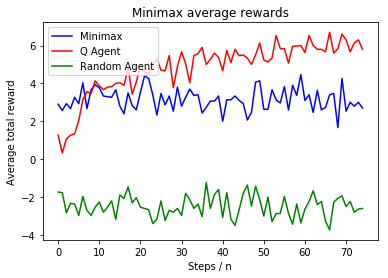

In [194]:
# Plots the 3 Policies.
x = np.arange(0, len(mini_avg_line))
plt.plot(x, mini_avg_line, color="blue", label="Minimax")
plt.plot(x, q_avg_line, color="red", label="Q Agent")
plt.plot(x, r_avg_line, color="green", label="Random Agent")
plt.ylabel("Average total reward")
plt.xlabel("Steps / n")
plt.title("Minimax average rewards")
plt.legend()
plt.show()

Explain your findings in 3 or fewer sentences. Which policy is better? Why?

<img src="images/minimaxcompare.png" style="width: 400px;"/>

Initially the minimax agent gets better rewards than the q agent, until the q agent has learnt a certain amount and eventually starts to do better. The issue with the minimax policy is that it plays optimally against an optimal player, as the agent picks moves uniformly at random, the minimax agent is having to play against not what it is expecting, causing the performance of the agent to detoriate. The minimax policy is still able to perform better than a random agent as there is some logic into how it plays, this is why you see the minimax agent having an average total reward of around 4.

## Part 3

Using your algorithm, compute the value of the game for your player (recall: your player goes second against a random opponent). The code cell below should compute this value and assign it to a variable called `optimal_policy_value`.

In [185]:
class Expecti:
    
    def __init__(self):
        self.branches = -1
        self.tree = {}
        
    def choose_action(self, e):
        """Chooses an action based on expectiminimax policy"""
        env = copy.deepcopy(e)
        actions = env.available_actions
        utilities = []
        for action in actions:
            current_env = copy.deepcopy(env)
            next_env = self.make_move(current_env, action)
            v = self.expectiminimax(next_env, counter="o",player="chance")
            utilities.append(v)
        i = np.argmax(utilities)
        return actions[i]
    
    def make_move(self, env, action):
        '''Gets next state of the game'''
        env.act(action)   
        return env
    
    def expectiminimax(self, env, counter="x", player="max"):
        self.branches += 1
        state = tuple(env.grid.flatten())
        
        if env.was_winning_move():
            if player == "chance":
                v = 1
            else:
                v = -1
            self.tree[state] = v
            return v 
        elif env.grid_is_full():
            v = 0
            self.tree[state] = v
            return v
        elif state in self.tree:
            return self.tree[state]
        else:
            if counter == "x":
                counter = "o"
            else:
                counter = 'x'
            env.change_turn()
            actions = env.available_actions
            if player == "max":
                v = -np.inf
                for action in actions:
                    current_env = copy.deepcopy(env)
                    next_env = self.make_move(current_env, action)
                    v = max(v, self.expectiminimax(next_env, counter, player="chance"))
            else:
                v = 0
                prob_of_actions = (1 / len(actions))
                for action in actions:
                    current_env = copy.deepcopy(env)
                    next_env = self.make_move(current_env, action)
                    if state in self.tree:
                        new_state = tuple(next_env.grid.flatten())
                        v_state = self.tree[state]
                        v += prob_of_actions * v_state
                    else:
                        v = v + (prob_of_actions * self.expectiminimax(next_env, counter, player="max"))
            self.tree[state] = v
            return v

In [184]:
# Run cell to get expectiminimax optimal state value.
t = time.process_time()          
env = connect.Connect(verbose=False)
env.reset(first_player='o')
env.act(action=1)
ex = Expecti()
optimal_policy_value = ex.expectiminimax(env)
print("Optimal policy value: ", optimal_policy_value)
elapsed_time = time.process_time() - t
print("Elapsed time: ", elapsed_time)

# optimal_policy_value = ...

Optimal policy value:  0.9775555555555557
Elapsed time:  15.463299999999435


In [180]:
expectiminimax_rewards = []
ex = Expecti()
for j in range(0, 30):
    total_reward = []
    for i in range(0, 75):
        rewards = policy_minimax(ex)
        total_reward.append(rewards)
    expectiminimax_rewards.append(total_reward)

In [181]:
# Takes output of cell above and averages it.
exmini_avg_line = []
for j in range(0, len(expectiminimax_rewards[1])):
    avg = 0
    for line in expectiminimax_rewards:
        avg += line[j]
    avg = avg / len(expectiminimax_rewards)
    exmini_avg_line.append(avg)

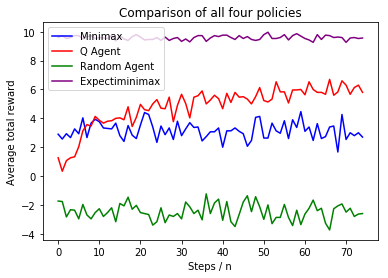

In [195]:
# Plots the 4 Policies.
x = np.arange(0, len(mini_avg_line))
plt.plot(x, mini_avg_line, color="blue", label="Minimax")
plt.plot(x, q_avg_line, color="red", label="Q Agent")
plt.plot(x, r_avg_line, color="green", label="Random Agent")
plt.plot(x, exmini_avg_line, color="purple", label="Expectiminimax")
plt.ylabel("Average total reward")
plt.xlabel("Steps / n")
plt.title("Comparison of all four policies")
plt.legend()
plt.show()

<img src="images/expecticompare.png" style="width: 400px;"/>

The expectiminimax has the best policy out of the ones tested. This is because it takes into consideration the randomness of the random agent, so it is able to model its moves better than the minimax agent was.

In [ ]:
# This is an autograded test cell. Do not delete or change, otherwise you will get 
# no marks for this part of the assignment. Please make sure that this cell has 
# access to the variable optimal_policy_value.